In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim 

In [2]:
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V

**Idea:** implement the searchK() function available in the `stm` package in R  
searchK() finds the optimal number of topics for a corpus by finding the exclusivity and semantic coherence of a model within a corpus. By varying the number of topics, the optimal number of topics can be found by maximising semantic coherence and exclusivity. 

**Trade-off:** Models with fewer topics have higher semantic coherence for more topics, but lower exclusivty. 


[STM exclusivity code](https://github.com/bstewart/stm/blob/master/R/exclusivity.R)

In [ ]:
### R

exclusivity <- function(model, M=10, frexw=.7){
  w <- frexw
  if(length(model$beta$logbeta)!=1) stop("Exclusivity calculation only designed for models without content covariates")
  tbeta <- t(exp(model$beta$logbeta[[1]])) 
    ## t -> transpose a matrix, beta -> List containing the log of the word probabilities for each topic, logbeta -> ??
  s <- rowSums(tbeta)
  mat <- tbeta/s #normed by columns of beta now.

  ex <- apply(mat,2,rank)/nrow(mat)
  fr <- apply(tbeta,2,rank)/nrow(mat)
  frex<- 1/(w/ex + (1-w)/fr)
  index <- apply(tbeta, 2, order, decreasing=TRUE)[1:M,]
  out <- vector(length=ncol(tbeta)) 
  for(i in 1:ncol(frex)) {
    out[i] <- sum(frex[index[,i],i])
  }
  out
}

In [ ]:
def get_exclusivity(run_id, word_num=10, frex_w=.7):
    """
    Calculates exclusivity for a topic model based on the association between word and topic, which is probabilistic for LDA
    """
    # create a dataframe from run_id 
    
    # normalise by sum of terms across topics 
    
    
    # find exclusivity by dividing individual TopicTerm score by sum of score of Term across all topics 
    
    # calculate frex using formula specified 
    
    # iterate over top 10 terms in all topics
    
    # return as sum of frex scores for top 10 terms in all topics 


### Getting data in appropriate format

In [27]:
run_id = 1350

In [6]:
len(list(TopicTerm.objects.filter(run_id=run_id)))

41967

In [45]:
tts = TopicTerm.objects.filter(run_id=run_id)

tts_n = tts.values('topic__title').annotate(
    n = Sum('score'),
    term = F('term__title')
).order_by('topic', '-n')

In [51]:
# df.to_pickle('df.pkl')
# df_p.to_pickle('df_p.pkl')

In [49]:
df = pd.DataFrame.from_dict(list(tts_n))
df    

,n,term,topic__title
0,0.262683,energi,"{energi, erneuerbar, prozent}"
1,0.227006,erneuerbar,"{energi, erneuerbar, prozent}"
2,0.092639,prozent,"{energi, erneuerbar, prozent}"
3,0.072123,energiew,"{energi, erneuerbar, prozent}"
4,0.062892,strom,"{energi, erneuerbar, prozent}"
5,0.049042,ausbau,"{energi, erneuerbar, prozent}"
6,0.032874,anteil,"{energi, erneuerbar, prozent}"
7,0.032286,eeg,"{energi, erneuerbar, prozent}"
8,0.031902,kraftwerk,"{energi, erneuerbar, prozent}"
9,0.031756,netz,"{energi, erneuerbar, prozent}"


In [50]:
df_p = df.pivot(index='topic__title', columns='term', values='n')
df_p

term,abbau,abbaus,abfall,abfallwirtschaft,abgab,abgebaut,abgegeb,abgeholzt,abgelehnt,abgeschaltet,...,zweck,zweckbind,zweckgebund,zwei,zweifel,zweifellos,zweit,zwischenlag,zwischenlager,„gleichwert
topic__title,,,,,,,,,,,,,,,,,,,,,
"{arbeitsplatz, deutschland, arbeitslos}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.007541,NaN,NaN,NaN,NaN,NaN,NaN
"{atomenergi, kons, gorleb}",NaN,NaN,0.062344,NaN,NaN,NaN,NaN,NaN,0.010066,NaN,...,NaN,NaN,NaN,NaN,0.014982,NaN,NaN,0.042864,0.007972,NaN
"{bahn, bau, schien}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.020379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"{bundeskanzl, deutschland, regier}",0.007424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"{burg, burgerinn, rotgrun}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"{ddr, rent, bergleut}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.019066,NaN,NaN,0.008884,NaN,NaN,NaN
"{deutschland, gut, gross}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.016968,NaN,NaN,0.016796,NaN,NaN,NaN
"{endlich, imm, merkel}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"{energi, erneuerbar, prozent}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# df_p2 = df.pivot(index='topic__title', columns='term', values='n')

In [53]:
df_p.shape

(40, 3048)

In [41]:
topics = Topic.objects.filter(run_id=run_id)

In [39]:
terms = Term.objects.filter(run_id=run_id)
len(list(terms))

15474

In [56]:
len(set(list(terms)))

15474

### Getting exclusivity

In [54]:
# create a dataframe from run_id 
# normalise by sum of terms across topics 
# find exclusivity by dividing individual TopicTerm score by sum of score of Term across all topics 
# calculate frex using formula specified 
# iterate over top 10 terms in all topics
# return as sum of frex scores for top 10 terms in all topics 

In [55]:
df_p.values

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan, 0.06234426, ..., 0.04286434, 0.00797156,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [62]:
# summing term scores across topics
df_p.sum(axis=0)

term
abbau               0.089519
abbaus              0.007535
abfall              0.171107
abfallwirtschaft    0.003101
abgab               0.028550
abgebaut            0.014715
abgegeb             0.016233
abgeholzt           0.012861
abgelehnt           0.032829
abgeschaltet        0.016414
abgeschloss         0.016131
abgesetzt           0.010455
abgewich            0.010951
abhang              0.317752
abhilf              0.008161
abholz              0.021648
abkassi             0.009187
abkomm              0.128079
ablehn              0.011887
abm                 0.002027
abmahn              0.008304
abs                 0.024907
absatz              0.008676
abschaff            0.129895
abschalt            0.034434
abscheid            0.048185
abschliess          0.032919
abschopf            0.009887
abschott            0.012780
absehbar            0.004063
                      ...   
zuletzt             0.037030
zumind              0.009951
zunach              0.010717
zunehm   

In [63]:
# divide term scores by sum of term scores across topics
# individual values are exclusivity scores
df_p.values/df_p.sum(axis=0).values

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan, 0.36435813, ..., 1.        , 1.        ,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [ ]:
# how arrange by scores in descending order, that is the question

### Getting coherence 

In [8]:
# Defining get_coherence
# Modified for parliament 
def get_coherence(run_id, search_id):
    stat = RunStats.objects.get(run_id=run_id)
    K = stat.K
    print("Getting coherence for {}".format(run_id))
    # obtain utterances in run_id 
    uts = pm.Utterance.objects.filter(search_matches=search_id)
    # obtain paragraphs from utterances in queryset  
    texts = []
    for ut in uts:
        pars = ut.paragraph_set.all()
        texts.append(" ".join([x.text for x in pars]))

    sentences = [get_sentence_g(x) for x in texts]
    model = gensim.models.Word2Vec(sentences)
    print("Calculating model similarity)")
    validation_measure = WithinTopicMeasure(
        ModelSimilarity(model)
    )

    term_rankings = []

    topics = Topic.objects.filter(
        run_id=run_id
    )

    for topic in topics:
        term_ranking = list(Term.objects.filter(
            topicterm__topic=topic
        ).order_by(
            '-topicterm__score'
        ).values_list('title',flat=True)[:50])
        term_rankings.append(term_ranking)

    stat.coherence = validation_measure.evaluate_rankings(
        term_rankings
    )
    stat.save()
    print("Coherence obtained.")
    print(stat.coherence)
    return

In [6]:
run_ids = [1350, 1351, 1352, 1353]

In [7]:
s = pm.Search.objects.get(id=44)

In [9]:
for run_id in run_ids:
    get_coherence(run_id, s)

Getting coherence for 1350
Calculating model similarity)
Coherence obtained.
0.4095878632824845
Getting coherence for 1351
Calculating model similarity)
Coherence obtained.
0.4170903415919083
Getting coherence for 1352
Calculating model similarity)
Coherence obtained.
0.40312689734446033
Getting coherence for 1353
Calculating model similarity)
Coherence obtained.
0.41716396235815933


In [3]:
sns.set_style('whitegrid')

In [4]:
Ks = [40, 50, 60, 70]

In [7]:
coherences = []
for run_id in run_ids:
    coherences.append(RunStats.objects.get(run_id=run_id).coherence)

In [13]:
coherences

[0.409587863282484, 0.417090341591908, 0.40312689734446, 0.417163962358159]

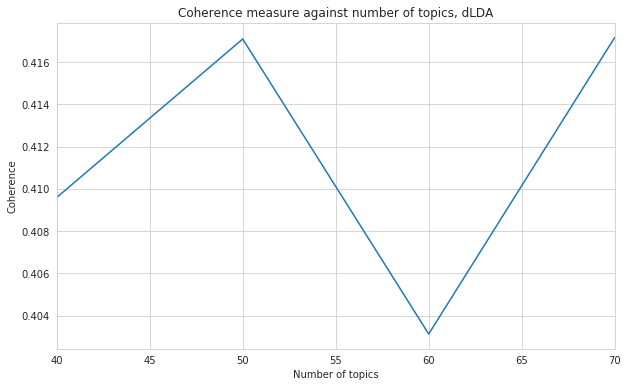

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(Ks, coherences, ax = ax)
ax.set(xlim=(40,70),xlabel="Number of topics",ylabel="Coherence", title="Coherence measure against number of topics, dLDA")
plt.show()